# UnbiasedGBM

:::{card} Unbiased gradient boosting decision tree with unbiased feature importance. (IJCAI2023)

- page: [Zhang, Z., Zhang, T., & Li, J. (2023, August). Unbiased gradient boosting decision tree with unbiased feature importance. In Proceedings of the Thirty-Second International Joint Conference on Artificial Intelligence (pp. 4629-4637).](https://dl.acm.org/doi/abs/10.24963/ijcai.2023/515)
- pdf: [arxiv.org/pdf/2305.10696v1](https://arxiv.org/pdf/2305.10696v1)

:::

## 概要

GBDTの分割（split）を決めるアルゴリズムには次のような バイアス（偏り） が存在することが問題になっている：

1. 特徴量の 分割候補の数（例えば連続値やカテゴリ数が多い特徴は多くの分割点を持てる）に依存して、有利になりやすい。
2. 分割の「改善度」（gain）を推定する際に、訓練データだけを使って評価するため、過学習や誤った重要度評価につながる。

この偏りにより、以下のような問題が起きる：

1. 解釈性（interpretability）が低くなる：実際には無関係な特徴量が高く評価されてしまう可能性。 
2. 過学習（overfitting）の原因となる：訓練データ上でよくなる分割を選びがちで、それが一般化性能を損なうことがある。 

これらの問題に対処するために、Unbiased GBMを提唱

UnbiasedGBMは60個のオープンデータセットのもとでXGBoostやLightGBMを有意に上回るパフォーマンスを出した

## 先行研究

- Quinlan (1986) は 分類木のバイアスに対処するため、 information gain ratio を提案
- [Sandri & Zuccolotto (2008)](https://www.tandfonline.com/doi/abs/10.1198/106186008X344522) は分類木の分割の改善を損失の減少と正のバイアスへと分解。疑似データセットを使ってバイアスを推定して減算する方法を提案。[Nembrini et al. (2018)](https://academic.oup.com/bioinformatics/article/34/21/3711/4994791) はこれを効率化させた。
    - → UnbiasedGBMでは計算量を大きく増加させる疑似データは使わない
- [Li, et al. (2019)](https://proceedings.neurips.cc/paper/2019/hash/702cafa3bb4c9c86e4a3b6834b45aedd-Abstract.html) はRandom ForestのMean Decrease Impurityのバイアスを改善したが、完全にはバイアスを除去できず残った。 
- [Zho & Hooker (2021)](https://dl.acm.org/doi/abs/10.1145/3429445) はRandom Forest とGBDT向けにUnbiased な Feature Importance を提案した。しかし平均二乗誤差を前提にした不偏性であったためGBDTに一般化は難しい。
    - → UnbiasedGBMでは特定の誤差関数の形状に依存せず、GBDTに一般化できる方法で不偏性の獲得をする

## GBDTのおさらい

### モデル

データセット $D=\{(\mathbf{x}, y)\}$ を考える。ここで $(\mathbf{x}, y)$ は未知の分布$\mathcal{T}$から独立に得られたとする。
決定木のアンサンブルは予測値を次のように出力する：

$$
\hat{y}=\phi(\mathbf{x})=\sum_{k=1}^K f_k(\mathbf{x}), f_k \in \mathcal{F}
$$

ここで $\mathcal{F}=\left\{f(\mathbf{x})=w_{q(\mathbf{x})}\right\}$ は回帰木の空間である。$q$は木の構造を示し、$q(\mathbf{x})$ は 事例 $\mathbf{x}$ の葉のインデックスへの写像である。


### 誤差関数

次の目的関数を最小化するように学習する。

$$
\mathcal{L}(\phi)=\mathbb{E}_{\mathbf{x}, y}[l(\phi(\mathbf{x}), y)]
$$

ここで$\phi_t$は$t$番目のイテレーションにおけるモデルを意味する。学習では貪欲的に、新たな回帰木$f_t$を追加したとき目的関数 $\mathcal{L}\left(\phi_{t-1}+f_t\right)$ を最小化するような回帰木を追加する。
この目的関数は二次近似で得られる

$$
\begin{gathered}
\mathcal{L}\left(\phi_{t-1}+f_t\right) \approx \mathbb{E}_{\mathbf{x}, y}\left[l\left(\hat{y}_{t-1}, y\right)+g(\mathbf{x}, y) f_t(\mathbf{x}) + \frac{1}{2} h(\mathbf{x}, y) f_t(\mathbf{x})^2\right]
\end{gathered}
$$

ここで

$$
g(\mathrm{x}, y)=\frac{\partial l\left(\phi_{t-1}(\mathrm{x}), y\right)}{\partial \phi_{t-1}(\mathrm{x})}, \quad
h(\mathrm{x}, y)=\frac{\partial^2 l\left(\phi_{t-1}(\mathrm{x}), y\right)}{\left(\partial \phi_{t-1}(\mathrm{x})\right)^2}
$$

定数項を消すことで

$$
\tilde{\mathcal{L}}\left(\phi_{t-1}+f_t\right)=\mathbb{E}_{\mathbf{x}, y}\left[g(\mathbf{x}, y) f_t(\mathbf{x})+\frac{1}{2} h(\mathbf{x}, y) f_t(\mathbf{x})^2\right]
$$

となる。

葉ノード$I$による損失関数への貢献は

$$
\begin{aligned}
\mathcal{L}(I) & =\mathbb{E}_{\mathbf{x}, y}\left[\mathbf{1}_{\{q(\mathbf{x})=I\}}\left(g(\mathbf{x}, y) f(x)+\frac{1}{2} h(\mathbf{x}, y) f(x)^2\right)\right] \\
& =\mathbb{E}_{\mathbf{x}, y}\left[\mathbf{1}_{\{q(\mathbf{x})=I\}}\left(g(\mathbf{x}, y) w_I+\frac{1}{2} h(\mathbf{x}, y) w_I^2\right)\right] \\
& =P(\mathbf{x} \in I)\left(\mu_g(I) w_I+\frac{1}{2} \mu_h(I) w_I^2\right)
\end{aligned}
$$

で、ここで

$$
\mu_g(I)=\mathbb{E}_{\mathbf{x}, y}[g(\mathbf{x}, y)]
\\
\mu_h(I)=\mathbb{E}_{\mathbf{x}, y}[h(\mathbf{x}, y)]
$$

である。葉ノード $I$ の最適な重み $w_I$ は、微分してゼロ（$\partial \mathcal{L}(I)/\partial w = 0$）とおいて整理すれば

$$
w_I=-\frac{\mu_g(I)}{\mu_h(I)}
$$

となるため、この$w_I$を損失関数に代入すれば、対応する最適な損失は

$$
\mathcal{L}(I)=-\frac{1}{2} \frac{\mu_g(I)^2}{\mu_h(I)} P(\mathrm{x} \in I) .
$$

となる。

### gain推定

左右に分割した子ノードの損失の和がもとのノードの損失より小さくなった分が情報利得（gain）である：


$$
\operatorname{Gain}(I, \theta)=\mathcal{L}(I)- \{ \mathcal{L}(I_L)+\mathcal{L}(I_R) \}
$$


実際には真の分布は未知なので標本を使った推定量（経験損失）を使う：

$$
\begin{aligned}
\widetilde{\mathcal{L}}(I) & =-\frac{1}{2} \frac{\left(\frac{1}{n_I} \sum_{i \in I} g_i\right)^2}{\frac{1}{n_I} \sum_{i \in I} h_i} \frac{n_I}{n}\\
&=-\frac{1}{2 n} \frac{G_I^2}{H_I}
\\
\widetilde{\operatorname{Gain}}(I, \theta) & =\frac{1}{2 n}\left(\frac{G_L^2}{H_L}+\frac{G_R^2}{H_R}-\frac{G_I^2}{H_I}\right)
\end{aligned}
$$

ここで

- $G_I=\sum_{i \in I} g_i$
- $H_I=\sum_{i \in I} h_i$
- $n_I$：ノード$I$の数


## Gain推定のバイアス

$\widetilde{\operatorname{Gain}}$ はある特徴量での分割による損失の減少を推定する。

直感的には、もし $\widetilde{\operatorname{Gain}}$ が不偏であれば、ランダムに分割した場合、期待値がゼロになるとおもわれる。しかし実際には、どの特徴量のどの分割点に対しても常に非負な値をもつ。

:::{admonition} 定理1

分布$\mathcal{T}$からサンプリングされたデータセット$(X, Y)$について、ノード$I$での所与の特徴量$X_j$の任意の分割点$\theta$について、常に

$$
\widetilde{\operatorname{Gain}}(I, \theta) \geq 0
$$

となる。

:::

::::{dropdown} 証明（Appendix Aより）

まず、$\tilde{\mathcal{L}}(I)$ を最適化の形に書き換える：

$$
\begin{aligned}
\tilde{\mathcal{L}}(I)
&= -\frac{1}{2n} \frac{G_I^2}{H_I} \\
&= \frac{1}{n} \min_w \left( \frac{1}{2} H_I w^2 + G_I w \right) \\
&= \frac{1}{n} \min_w \sum_{i \in I} \left( \frac{1}{2} h_i w^2 + g_i w \right)\\
&= \frac{1}{n} \min_w \sum_{i \in I} l_i(w)
\end{aligned}
$$

ここで、$l_i(w) = \frac{1}{2} h_i w^2 + g_i w$ である。


$I = I_L \cup I_R$ であるため、$L$ および $R$ の最適損失の合計は $I$ の最適損失よりも小さい。したがって、

$$
\begin{aligned}
\widetilde{\mathrm{Gain}}(I, \theta)
&= \tilde{\mathcal{L}}(I) - \tilde{\mathcal{L}}(I_L) - \tilde{\mathcal{L}}(I_R)\\
&= \frac{1}{n}
\left(
\min_w \sum_{i \in I} l_i(w)
- \min_{w_L} \sum_{i \in I_L} l_i(w_L)
- \min_{w_R} \sum_{i \in I_R} l_i(w_R)
\right)\\
&\ge 0
\end{aligned}
$$


:::{card} Discussion：Gainが0となる場合について

上式から、$\widetilde{\mathrm{Gain}}(I, \theta) = 0$ が成り立つのは次の場合に限られる：

$$
w^* = w_L^* = w_R^*
$$

すなわち次の関係が成り立つときである：

$$
\frac{G_L}{H_L} = \frac{G_R}{H_R}
$$

これは、$\widetilde{\mathrm{Gain}}(I, \theta) = 0$ となるための必要十分条件であるが、実際の応用においてこの条件が成立することは極めて稀である。
:::

::::

定理1により

1. 有益な情報をもたらさない特徴量の上で不要な分割をする可能性がある（→学習に悪影響）
2. 正のgainであっても、その特徴量が本当にモデルに貢献しているとは限らない（→Feature Importanceが不正確になる）


#### 勾配推定のバイアス

gain推定のバイアスの原因のひとつは、勾配の期待値の推定量  $G_I^2 = (\sum_{i \in I} g_i)^2$ が真値$\mu_g^2 = (\mathbb{E}_{\mathbf{x}, y}[g(\mathbf{x}, y)])^2$の不偏推定量ではないこと

$$
\begin{aligned}
\mathbb{E}_{\mathcal{D}}\left[\left(\frac{1}{n_I} \sum_{i \in I} g_i\right)^2\right]
&= \mathbb{E}_{\mathcal{D}}\left[\frac{1}{n_I^2} \sum_{i, j \in I, i \neq j} 2 g_i g_j\right]+\mathbb{E}_{\mathcal{D}}\left[\frac{1}{n_I^2} \sum_{i \in I} g_i^2\right] \\
&= \frac{n_I-1}{n_I} \mu_g(I)^2+\frac{1}{n_I}\left(\mu_g(I)^2+\sigma_g(I)^2\right) \\
&= \mu_g(I)^2+\frac{1}{n_I} \sigma_g(I)^2
\end{aligned}
$$


#### 例：MSE

MSEによる回帰問題は、ヘシアンが定数であることを考えると（2乗誤差$\frac{1}{2}(y -\hat{y})^2$のgradientは残差$y - \hat{y}$、hessianは$-1$）、葉$I$の損失

$$
\begin{aligned}
\widetilde{\mathcal{L}}(I) &= -\frac{1}{2} \frac{\left(\frac{1}{n_I} \sum_{i \in I} g_i\right)^2}{\frac{1}{n_I} \sum_{i \in I} h_i} \frac{n_I}{n}\\
&= \frac{1}{2 n} n_I \left(\frac{1}{n_I} \sum_{i \in I} g_i\right)^2\\
\end{aligned}
$$

の期待値は

$$
\mathbb{E}_{\mathcal{D}}[\widetilde{\mathcal{L}}(I)]=\frac{1}{2 n}\left(\mathbb{E}_{\mathcal{D}}\left[n_I\right] \mu_g(I)^2+\sigma_g(I)^2\right)
$$

となる。


目的変数と独立であり有益な情報のない（uninformativeな）特徴量については、任意の分割点において常に

$$
\mu_g(I)=\mu_g\left(I_L\right)=\mu_g\left(I_R\right)
\\
\sigma_g(I)=\sigma_g\left(I_L\right)=\sigma_g\left(I_R\right)
$$

となる。（例えば二乗誤差の勾配は残差だが、uninformativeな特徴量ならどこで分割しても残差の期待値は変わらない、みたいな。）


よって、uninformativeな特徴量における分割のgainは

$$
\begin{aligned}
\mathbb{E}_{\mathcal{D}}[\widetilde{\operatorname{Gain}}(I, \theta)]
&= \mathbb{E}_{\mathcal{D}}\left[\widetilde{\mathcal{L}}\left(I_L\right)\right]+\mathbb{E}_{\mathcal{D}}\left[\widetilde{\mathcal{L}}\left(I_R\right)\right]-\mathbb{E}_{\mathcal{D}}[\widetilde{\mathcal{L}}(I)] \\
&= \frac{1}{2 n}\left(\sigma_g(I)^2+\mathbb{E}_{\mathcal{D}}\left[n_L+n_R-n_I\right] \mu_g(I)^2\right) \\
&= \frac{1}{2 n} \sigma_g(I)^2 \geq 0
\end{aligned}
$$


### 分割点探索におけるバイアス

木は学習の際に損失をもっとも下げる最適な分割点を探索する。

この戦略は2つの問題をもたらす：

1. 分割点の探索はカーディナリティの高い特徴量（連続変数やカテゴリ数の多いカテゴリカル変数）を高く評価する。カーディナリティが高いと分割候補点が多いため、分割される尤もらしさが大きくなる。
2. 分割探索アルゴリズムは汎化性能を考慮せず訓練データでの最適解を選ぶ

この問題について、例を使ってさらに説明する

#### 例

合成データを生成するとする。

- $X_1$は二値変数
- $X_2$は6つのカテゴリをもつカテゴリカル変数とする（各カテゴリは一様に分布）
- $X_3 \sim N(0,1)$は連続変数
- $y = 0.1 X_1 + \epsilon$ の目的変数への回帰問題を考える
    - ここで $\epsilon \sim N(0, 1)$

つまり、真のimportanceとしては$X_1$だけが正の値になるはず、というデータになっている。

これを実行してみると$X_3$のimportanceが高く推定される（なおLightGBMのsplit importanceでも同様）


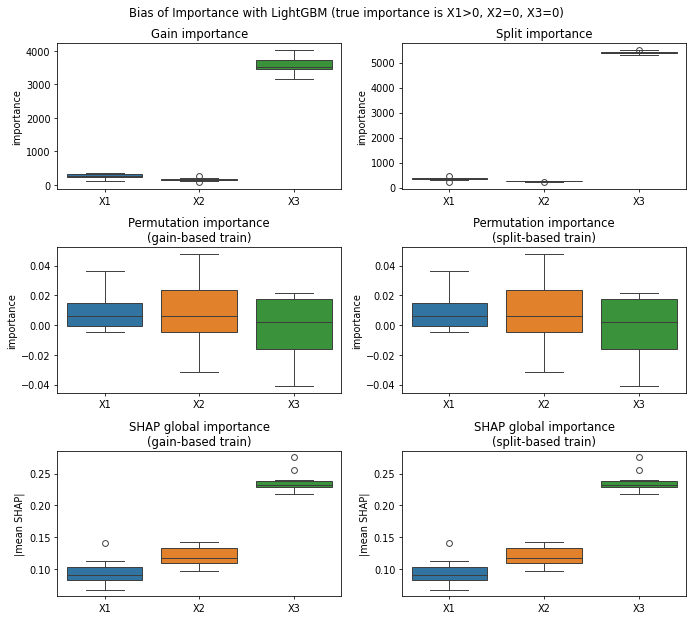

In [37]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor
import shap
import contextlib
import io

def gen_data(n, seed):
    rng = np.random.default_rng(seed)
    # X1: 二値, X2: 6カテゴリ(一様), X3: 連続 N(0,1)
    X1 = rng.integers(0, 2, size=n)
    X2 = rng.integers(0, 6, size=n)
    X3 = rng.normal(0, 1, size=n)
    # y = 0.1 * X1 + ε,  ε ~ N(0,1)
    epsilon = rng.normal(0, 1, size=n)
    y = 0.1 * X1 + epsilon
    df = pd.DataFrame({
        "X1": X1,
        "X2": pd.Series(X2, dtype="category"),  # LightGBM sklearn APIはcategory dtypeを解釈可能
        "X3": X3,
        "y": y
    })
    X = df[["X1", "X2", "X3"]]
    y = df["y"]
    return X, y


def trial(n, seed):
    X_train, y_train = gen_data(n=n, seed=seed)
    X_test, y_test = gen_data(n=n, seed=seed + 1)
    params = dict(
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_samples=20,
        force_col_wise=True,  # 小規模データでの起動オーバーヘッド削減
        random_state=0,
    )
    feat_names = ["X1", "X2", "X3"]
    results = []

    for importance_type in ["gain", "split"]:
        model = LGBMRegressor(**params, importance_type=importance_type)
        with contextlib.redirect_stdout(io.StringIO()):
            model.fit(X_train, y_train)

        # LightGBM built-in importance
        importances = model.feature_importances_
        feat_imp = dict(zip(feat_names, importances))
        results.append(dict(importance_type=importance_type, **feat_imp))

        # Permutation importance
        pi = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=123)
        pi_mean = pi.importances_mean
        perm_imp = dict(zip(feat_names, pi_mean))
        results.append(dict(importance_type=f"permutation-{importance_type}", **perm_imp))

        # SHAP importance（global mean absolute shap）
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        # shap_values.shape = (n_samples, n_features)
        shap_mean_abs = np.abs(shap_values).mean(axis=0)
        shap_imp = dict(zip(feat_names, shap_mean_abs))
        results.append(dict(importance_type=f"shap-{importance_type}", **shap_imp))

    return results


# run ----------------------------------------
n_trials = 10
results = [trial(n=1000, seed=seed) for seed in range(n_trials)]
results = sum(results, [])
results = pd.DataFrame(results)

# plot ----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize=[10, 9], ncols=2, nrows=3, dpi=70)

sns.boxplot(results.query("importance_type == 'gain'"), ax=axis[0,0])
axis[0,0].set(title="Gain importance", ylabel="importance")

sns.boxplot(results.query("importance_type == 'split'"), ax=axis[0,1])
axis[0,1].set(title="Split importance", ylabel="importance")

sns.boxplot(results.query("importance_type == 'permutation-gain'"), ax=axis[1,0])
axis[1,0].set(title="Permutation importance\n(gain-based train)", ylabel="importance")

sns.boxplot(results.query("importance_type == 'permutation-split'"), ax=axis[1,1])
axis[1,1].set(title="Permutation importance\n(split-based train)", ylabel="importance")

sns.boxplot(results.query("importance_type == 'shap-gain'"), ax=axis[2,0])
axis[2,0].set(title="SHAP global importance\n(gain-based train)", ylabel="|mean SHAP|")

sns.boxplot(results.query("importance_type == 'shap-split'"), ax=axis[2,1])
axis[2,1].set(title="SHAP global importance\n(split-based train)", ylabel="|mean SHAP|")

fig.suptitle("Bias of Importance with LightGBM (true importance is X1>0, X2=0, X3=0)")
fig.tight_layout()
plt.show()


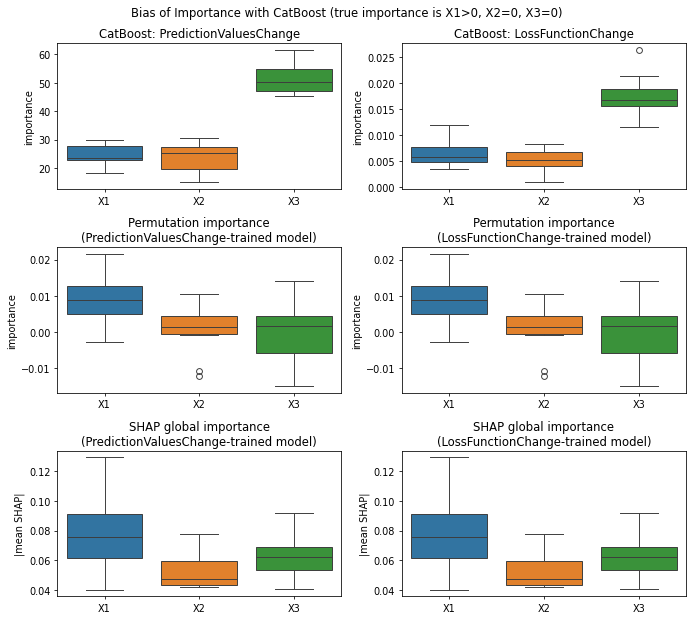

In [52]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor, Pool
import contextlib
import io

def gen_data(n, seed):
    rng = np.random.default_rng(seed)
    # X1: 二値, X2: 6カテゴリ(一様), X3: 連続 N(0,1)
    X1 = rng.integers(0, 2, size=n)
    X2 = rng.integers(0, 6, size=n)
    X3 = rng.normal(0, 1, size=n)
    # y = 0.1 * X1 + ε,  ε ~ N(0,1)
    epsilon = rng.normal(0, 1, size=n)
    y = 0.1 * X1 + epsilon
    df = pd.DataFrame({
        "X1": X1,
        "X2": pd.Series(X2, dtype="category"),  # CatBoostではcat_features指定で扱う
        "X3": X3,
        "y": y
    })
    X = df[["X1", "X2", "X3"]]
    y = df["y"]
    return X, y


def trial(n, seed):
    X_train, y_train = gen_data(n=n, seed=seed)
    X_test, y_test = gen_data(n=n, seed=seed + 1)

    params = dict(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        subsample=0.9,
        rsm=0.9,
        l2_leaf_reg=3.0,
        random_seed=0,
        loss_function='RMSE',
        verbose=False,
        allow_writing_files=False
    )
    cat_idx = [1]  # X2のみカテゴリ変数
    feat_names = ["X1", "X2", "X3"]
    results = []

    # CatBoost内蔵のimportanceタイプ
    importance_types = [
        ("PredictionValuesChange", "pvc"),
        ("LossFunctionChange", "lfc"),
    ]

    for imp_type, short in importance_types:
        model = CatBoostRegressor(**params)
        with contextlib.redirect_stdout(io.StringIO()):
            model.fit(X_train, y_train, cat_features=cat_idx)

        train_pool = Pool(X_train, y_train, cat_features=cat_idx)
        test_pool = Pool(X_test, y_test, cat_features=cat_idx)

        # (1) 内部重要度
        importances = model.get_feature_importance(train_pool, type=imp_type)
        feat_imp = dict(zip(feat_names, importances))
        results.append(dict(importance_type=imp_type, **feat_imp))

        # (2) パーミュテーション重要度
        pi = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=123)
        pi_mean = pi.importances_mean
        perm_imp = dict(zip(feat_names, pi_mean))
        results.append(dict(importance_type=f"permutation-{short}", **perm_imp))

        # (3) SHAP（global mean absolute shap）
        shap_values = model.get_feature_importance(test_pool, type="ShapValues")
        # shap_values.shape = (n_samples, n_features + 1) 最後の列がbase value
        shap_values = shap_values[:, :-1]
        shap_mean_abs = np.abs(shap_values).mean(axis=0)
        shap_imp = dict(zip(feat_names, shap_mean_abs))
        results.append(dict(importance_type=f"shap-{short}", **shap_imp))

    return results


# run ----------------------------------------
n_trials = 10
results = [trial(n=1000, seed=seed) for seed in range(n_trials)]
results = sum(results, [])
results = pd.DataFrame(results)

# plot ----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize=[10, 9], ncols=2, nrows=3, dpi=70)

sns.boxplot(results.query("importance_type == 'PredictionValuesChange'"), ax=axis[0,0])
axis[0,0].set(title="CatBoost: PredictionValuesChange", ylabel="importance")

sns.boxplot(results.query("importance_type == 'LossFunctionChange'"), ax=axis[0,1])
axis[0,1].set(title="CatBoost: LossFunctionChange", ylabel="importance")

sns.boxplot(results.query("importance_type == 'permutation-pvc'"), ax=axis[1,0])
axis[1,0].set(title="Permutation importance\n(PredictionValuesChange-trained model)", ylabel="importance")

sns.boxplot(results.query("importance_type == 'permutation-lfc'"), ax=axis[1,1])
axis[1,1].set(title="Permutation importance\n(LossFunctionChange-trained model)", ylabel="importance")

sns.boxplot(results.query("importance_type == 'shap-pvc'"), ax=axis[2,0])
axis[2,0].set(title="SHAP global importance\n(PredictionValuesChange-trained model)", ylabel="|mean SHAP|")

sns.boxplot(results.query("importance_type == 'shap-lfc'"), ax=axis[2,1])
axis[2,1].set(title="SHAP global importance\n(LossFunctionChange-trained model)", ylabel="|mean SHAP|")

fig.suptitle("Bias of Importance with CatBoost (true importance is X1>0, X2=0, X3=0)")
fig.tight_layout()
plt.show()


### バイアスの原因まとめ

バイアスの原因は

1. 最適分割探索のアルゴリズムのバイアス
    - 最適な分割の探索とGainの評価を同じデータセットで行っているため過学習のバイアスが入る
2. Gainの推定量におけるバイアス



## Unbiased Gain

2つのバイアスの原因に対処するために、データの分割と推定の計算を変える

**前提**

訓練データセット $ \mathcal{D} = \{(x_i, y_i)\} $ と検証データセット $ \mathcal{D}' = \{(x_i', y_i')\} $ を持っていると仮定する。

ある葉ノード $I$ と分割 $I = I_L \cup I_R$ に対して、葉 $I, I_L, I_R$ にそれぞれ $n_I, n_L, n_R$ 個の訓練データと$n'_I, n'_L, n'_R$ 個の検証データが含まれるとする。

**手順**

まず、訓練データを用いて $\mu_g(I)$ を次のように推定する。

$$
\hat{\mu}_g(I) = \frac{1}{n_I} G_I = \frac{1}{n_I} \sum_{q(x_i)=I} g_i
$$

次に、検証データの中から各ノードにおいて $k = \min(n'_L, n'_R)$ 個のサンプルをランダムに選択する。

その $k$ 個の検証サンプルを用いて、$\mu_g(I)$ および $\mu_h(I)$ を次のように推定する。

$$
\hat{\mu}'_g(I) = \frac{1}{k} G'_I = \frac{1}{k} \sum_{q(x_i')=I} g_i' \cdot \delta(I, i)
$$

$$
\hat{\mu}'_h(I) = \frac{1}{k} H'_I = \frac{1}{k} \sum_{q(x_i')=I} h_i' \cdot \delta(I, i)
$$

ここで、$\delta(I, i)$ はバイナリ指示関数であり、検証サンプル $i$ が選択された場合に $1$、そうでない場合に $0$ となる。

最後に、葉ノード $I$ の損失を次のように計算する。

$$
\tilde{\mathcal{L}}(I)
= \frac{1}{2} \frac{\hat{\mu}_g(I) \cdot \hat{\mu}'_g(I)}{\hat{\mu}'_h(I)} \cdot \frac{n_I}{n}
= -\frac{1}{2n} G_I \cdot \frac{G'_I}{H'_I}
$$

ここで、$G_I$ は訓練データから計算され、
$G'_I$ および $H'_I$ は検証データから計算される。

同様にして、$\tilde{\mathcal{L}}(I_L)$ および $\tilde{\mathcal{L}}(I_R)$ も計算できる。
このとき、選択される検証サンプルの数 $k$ は $I, I_L, I_R$ すべてにおいて同じである。

最終的に、Unbiased Gainは次のように計算される

$$
\widetilde{\operatorname{Gain}}_{\mathrm{ub}}(I, \theta)=\widetilde{\mathcal{L}}(I)-\widetilde{\mathcal{L}}\left(I_L\right)-\widetilde{\mathcal{L}}\left(I_R\right)
$$


:::{admonition} 定理2

特徴量 $X_j$、葉ノード $I$、および分割 $\theta$ に対して、もし $X_j$ が葉ノード $I$ により定義される領域内で $y$ と周辺的に独立であるならば、

$$
\mathbb{E}_{\mathcal{D}'} \left[ \widetilde{\mathrm{Gain}}_{\mathrm{ub}}(I, \theta) \right] = 0
$$

が成立する。

:::

Unbiased gain の設計上の重要な点は、$\mu_g(I)$、$\mu_g(I_L)$、および $\mu_g(I_R)$ を ノード $I, I_L, I_R$ に含まれるすべての検証サンプルを用いて推定するのではなく、それぞれのノードからランダムに $k$ 個のサンプルを抽出して推定を行う点にある。

この設計により、不偏性が保証される。


:::{dropdown} 証明

（Appendix Bより）

$\hat{\mu}_g'(I)$、$\hat{\mu}_g'(I_L)$、$\hat{\mu}_g'(I_R)$、および $\hat{\mu}_h'(I)$、$\hat{\mu}_h'(I_L)$、$\hat{\mu}_h'(I_R)$ はすべて、同じ数のサンプル $k$ によって推定されるので、

$$
\forall k, \quad 
\mathbb{E}\!\left[\frac{\hat{\mu}_g'(I)}{\hat{\mu}_h'(I)} \,\middle|\, k\right]
= \mathbb{E}\!\left[\frac{\hat{\mu}_g'(I_L)}{\hat{\mu}_h'(I_L)} \,\middle|\, k\right]
= \mathbb{E}\!\left[\frac{\hat{\mu}_g'(I_R)}{\hat{\mu}_h'(I_R)} \,\middle|\, k\right]
\tag{8}
$$

ここで、$\mathbb{E}$ は $\mathbb{E}_{\mathcal{D}'}$ の略記である。したがって、

$$
\begin{aligned}
\mathbb{E}\!\left[\widetilde{\mathrm{Gain}}_{\text{ub}}\right]
&= \mathbb{E}\!\left[\widetilde{\mathcal{L}}_{\text{ub}}(I)\right]
 - \mathbb{E}\!\left[\widetilde{\mathcal{L}}_{\text{ub}}(I_L)\right]
 - \mathbb{E}\!\left[\widetilde{\mathcal{L}}_{\text{ub}}(I_R)\right] \\[4pt]
&= -\frac{G_I}{2n}\,\mathbb{E}\!\left[\frac{\hat{\mu}_g'(I)}{\hat{\mu}_h'(I)}\right]
 + \frac{G_L}{2n}\,\mathbb{E}\!\left[\frac{\hat{\mu}_g'(I_L)}{\hat{\mu}_h'(I_L)}\right]
 + \frac{G_R}{2n}\,\mathbb{E}\!\left[\frac{\hat{\mu}_g'(I_R)}{\hat{\mu}_h'(I_R)}\right] \\[4pt]
&= \frac{G_L + G_R - G_I}{2n}
   \sum_k P(k)\,
   \mathbb{E}\!\left[\frac{\hat{\mu}_g'(I)}{\hat{\mu}_h'(I)} \,\middle|\, k\right] \\[4pt]
&= 0
\end{aligned}
$$

:::

### The Motivation Behind the Unbiased Gain (Appendix B.1)

**なぜ追加の検証セットが必要なのか?**  
直感的な説明としては、「同じデータセットを使用して最適な分割を見つけて評価するべきではない」ということ。

**検証セットを用いて損失の減少を再計算することは可能か?**  
検証セットを用いる直感的な方法は、ツリー構造を固定し、検証セットを用いて損失の減少を再計算すること。しかし、情報価値のない特徴量に基づく分割の場合、検証セットを用いて評価される分割ゲインは（ゼロではなく）負の値になることが予想される。


**なぜランダムに$k$サンプルを抽出する必要があるのか？**  
もし $\hat{\mu}_g'(I)$、$\hat{\mu}_g'(I_L)$、$\hat{\mu}_g'(I_R)$、および $\hat{\mu}_h'(I)$、$\hat{\mu}_h'(I_L)$、$\hat{\mu}_h'(I_R)$ が異なる数のサンプルから推定されると、証明の式(8)は成り立たない  
（サンプルサイズが違うと、大数の法則によって一致する速度が異なってしまうため？）

### 人工データでの例

前出の人工データによるシミュレーション実験においてもUnbiasedGain （Figure 1(b)）は $X_1$のGainを適切に評価している

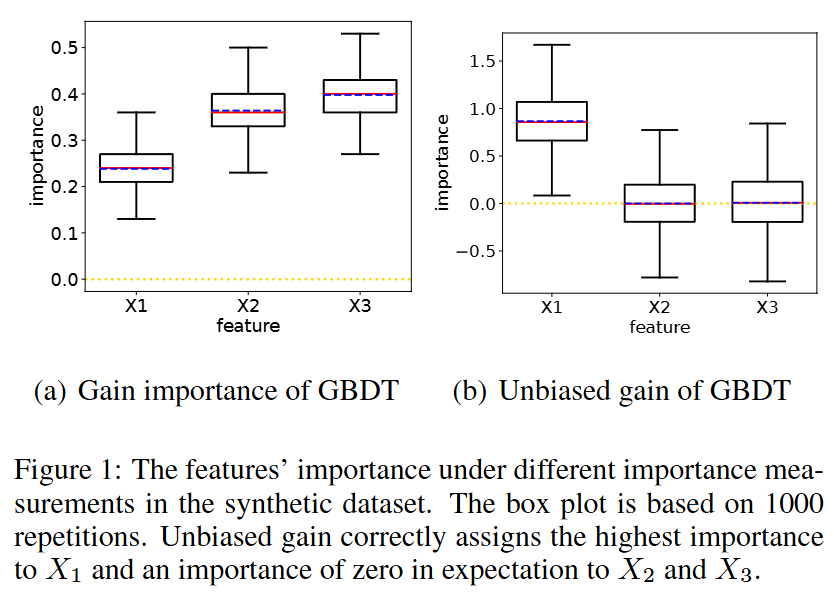

## UnbiasedGBM

GBDTのバイアスは2点あった：

1. カーディナリティが高い特徴についての分割選択がバイアスをもつ
2. 汎化性能は考えずに訓練データでの最適分割を選ぶため、過学習しやすい

これらに対応するため、最適分割探索アルゴリズムを改良する。

:::{admonition} UnbiasedGBMの最適分割探索

1. 訓練データをsub-training set $\mathcal{D}$ と validation set $\mathcal{D}_1', \mathcal{D}_2'$ に分割する。
2. $\mathcal{D}$ で 各分割点における $\widetilde{\mathrm{Gain}}_1$ を計算し、各特徴量の **最適な分割を決定する**
3. $\mathcal{D}_1'$ で各特徴量の最適な分割における $\widetilde{\mathrm{Gain}}_2$ を計算する。そして使用する **特徴量を決定する** 。
4. $\mathcal{D}_2'$ を使い、最適な分割点における $\widetilde{\mathrm{Gain}}_{\mathrm{ub}}$ を計算して分割の汎化性能を推定する。
5. もし $\widetilde{\mathrm{Gain}}_{\mathrm{ub}} > 0$ なら葉ノードを分割し、 $\widetilde{\mathrm{Gain}}_{\mathrm{ub}} \leq 0$ なら停止する（early-stopping）。

:::


### Remark

- 最適な分割の探索と最適な特徴量の探索を異なるデータセットで行っているので、高いカーディナリティによるバイアスを除去できる。
- $\widetilde{\mathrm{Gain}}_{\mathrm{ub}} \leq 0$ なら学習を停止するのはfeature importanceの不偏性を保つために行っている。
    - gainが小さいときに学習を止めるleaf-wise early-stoppingは既存手法（LightGBMなど）にもあるが、UnbiasedGBMは汎化性能を考慮している点と、学習停止の閾値の設定に理論的根拠がある点が異なる


### データの分割について

データをどういう比率で $\mathcal{D}, \mathcal{D}_1', \mathcal{D}_2'$ に分割すればいいのか？

異なる比率での分割を試す実験を行ったところ、同数に分割する $|\mathcal{D}| = |\mathcal{D}_1'| = |\mathcal{D}_2'|$ のが一番よかった（Appendix E）

## 数値実験

### 予測性能の実験

提案論文における実験では、60個以上のオープンデータセットのもとでUnbiasedGBMとXGBoost, LightGBM, CatBoostを比較している。

ハイパーパラメータチューニングはOptunaで100以上のepochsをチューニングする方法で行った

UnbiasedGBMは平均で1.72位で最も良かった

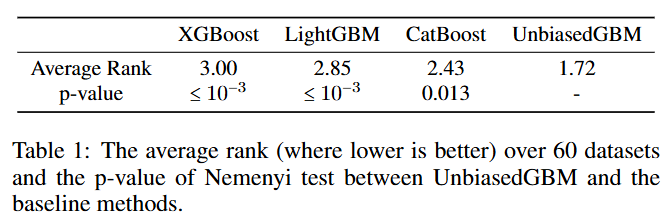

### 特徴選択の実験

次の手法と比較する

- Gain importance [Breiman et al., 1984]
- Permutation feature importance (PFI) [Breiman, 2001]
-  SHAP [Lundberg et al., 2018]

Forman and others (2003) の手法に従い、feature importanceの手法を比較する。

:::{card} Forman and others (2003)の比較法

1. 所与のデータセットのもとで、training setを用いて feature importance を推定する
2. feature importanceに従ってtop $k$% の特徴量を選択する
3. 選択した特徴量でGBDTモデルを構築する
5. test setのもとでAUCを計算する

高いAUCが得られる特徴量の集合を選べた手法ほど、よい特徴量選択ができていると考える。

:::


$k \in\{10,20,30\}$ として、30以上の特徴量をもつ14個のデータセットのもとで比較した結果が Figure 4である。縦軸は14データセットでの平均AUCと分散を示している。

unbiased gainが平均的に良いパフォーマンスを示している。

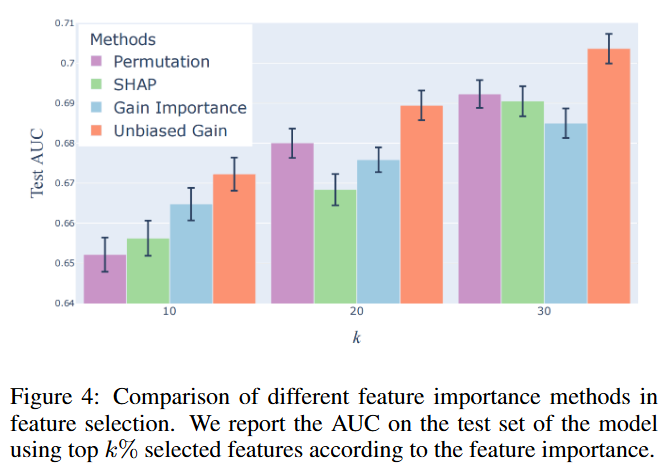

## 計算量

$n$ をサンプル数、$m$ をデータセットの基本特徴量の数とする。  
各サンプルは各深さにおいてちょうど一度ずつ現れるため、最大深さを $d$ としたとき、UnbiasedGBMは次の計算量で動作する：

$$
O(T d n m \log n)
$$

ここで、$T$ は木の本数を表す。  
この計算量は XGBoost とまったく同じであり、同様にブロック構造上では $O(T d n m + n m \log n)$ のコストを要する。  
（XGBoostはLightGBMのようなhistogram-tree実装もあるが、exact treeの話をしている？？）

実際のところ、UnbiasedGBMの手法を既存の GBDT 実装に適用しても時間計算量は保たれる。  
なぜなら、これは 2 つの分割済みデータセット $D'_1$ および $D'_2$ を別々に計算する場合よりも悪化することはないからである。

（Appendix E.3より）


## コード

著者の実装

[ZheyuAqaZhang/UnbiasedGBM: repository for Unbiased Gradient Boosting Decision Tree with Unbiased Feature Importance](https://github.com/ZheyuAqaZhang/UnbiasedGBM)